### Exploring Aging Curves using FIFA Player Ratings

The following notebook will show how to construct Aging Curves for soccer players using scores from the series of FIFA games. The dataset is sliced by individual, position and team to study how soccer players age.


#### FIFA Player Ratings

One of the scripts in this Github repo scrapes the website www.sofifa.com to obtain the full history of all FIFA player ratings. This is the dataset we will use in this notebook. Before we dive in, let's spend a moment on the ratings themselves. What do they mean?

A FIFA player rating is a score between 0 and 100 that measures the overall skill level of a player. The process by which this score is determined is described in the following article: https://www.dreamteamfc.com/c/gaming/133678/fifa-19-ratings-ultimate-team-cristiano-ronaldo/. Rating scores are available from August 2006 onwards - for the early years in the dataset, only annual ratings are available. In more recent years, player ratings have been updated as frequently as bi-weekly. In addition, the universe of clubs (and therefore players) has increased dramatically since the earliest FIFA game in our dataset.

There are many potential shortcomings of the FIFA player rating dataset - for example, we do not know whether these ratings have been determined using a consistent methodology since 2006. However, in a sport like soccer where it is difficult to quantify the performance of individual players across teams, countries and positions using a single score, FIFA ratings may actually be one of the best ways to produce aging curves. Let's see what we can learn!

In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# turn off the SettingWithCopy warning 
pd.options.mode.chained_assignment = None

#### Preparing the dataset

As a first step, let us load the full dataset. It will be helpful to simplify the 'position' column by designating the first position listed as a player's main position.

In [324]:
compressed_fifa_ratings = pd.read_csv('data/compressed_player_rating_dataset.csv', encoding='latin-1')
# compressed_fifa_ratings.set_index('player_url', inplace=True)

parsed_positions = compressed_fifa_ratings['position'].str.split(' ', expand=True)
parsed_positions.columns = ['main_position', 'position_2', 'position_3', 'position_4']
compressed_fifa_ratings = pd.concat([compressed_fifa_ratings, parsed_positions], axis=1)

compressed_fifa_ratings.drop(['Unnamed: 0', 'position'], axis=1, inplace=True)
compressed_fifa_ratings.head(5)

,name,age,overall,potential,team,nationality,rating_date,main_position,position_2,position_3,position_4
0,Patrick Deman,44,52,52,KV Kortrijk,Belgium,10/25/2013,GK,None,None,None
1,Marko Rehmer,34,75,79,Eintracht Frankfurt,Germany,8/30/2006,CB,None,None,None
2,Stijn Stijnen,25,70,78,Club Brugge KV,Serbia,8/30/2006,GK,None,None,None
3,Stijn Stijnen,25,70,78,Club Brugge KV,Belgium,2/22/2007,GK,None,None,None
4,Stijn Stijnen,26,71,73,Club Brugge KV,Belgium,8/30/2007,GK,None,None,None


#### Aging Curves

Now that we have our raw dataset ready to go, let us spend a moment discussing the methodology we will use to produce an 'aging curve'. The preferred method of calculating the aging curve has long been the 'delta method', described by Mitchel Lichtman in the link below:
https://www.fangraphs.com/tht/how-do-baseball-players-age-part-1/

Broadly, the delta method compares how individual players perform in back-to-back years. This information is then aggregated to produce an average change in performance over the course of a typical career.

In [325]:
just_overall_ratings = compressed_fifa_ratings[['name', 'team', 'age', 'main_position', 'overall']].drop_duplicates()
just_overall_ratings['age_next_year'] = just_overall_ratings['age'].apply(lambda x: x+1)
year_over_year_ratings = pd.merge(just_overall_ratings, just_overall_ratings, left_on=['name', 'age_next_year'],
                                  right_on=['name', 'age'], how='left').drop_duplicates()
year_over_year_ratings = year_over_year_ratings[['name', 'main_position_x', 'team_y', 'age_x', 'age_next_year_x', 'overall_x', 'overall_y']]
year_over_year_ratings.columns = ['name', 'main_position', 'team', 'age', 'age_next_year', 'overall', 'next_year_overall']
year_over_year_ratings.dropna(inplace=True)

year_over_year_ratings['diff'] = year_over_year_ratings['next_year_overall'] - year_over_year_ratings['overall']

To begin with, let us create the average aging curve for all the players in our dataset. Not all transitions from one age to the next will be sufficiently represented in our dataset. To begin with, let's establish which ages to use as cutoff points when building our aging curves.

In [334]:
year_over_year_ratings['age_couplet'] = year_over_year_ratings['age'].map(str) + '/' + year_over_year_ratings['age_next_year'].map(str)

avg_rating_changes = year_over_year_ratings.groupby(['age_couplet'], as_index=False)['diff'].count().set_index('age_couplet')
avg_rating_changes.columns = ['N']
avg_rating_changes

,N
age_couplet,
14/15,1
15/16,84
16/17,3639
17/18,14972
18/19,29432
19/20,39795
20/21,44250
21/22,45723
22/23,46170


It appears that the number of observations drops quite dramatically for age couplets under 16/17, and for age couplets over 37/38. As such, we will build our aging curves for players with ages between 16 and 38.

As a next step, we can construct our first aging curve for the full population of players in our dataset.

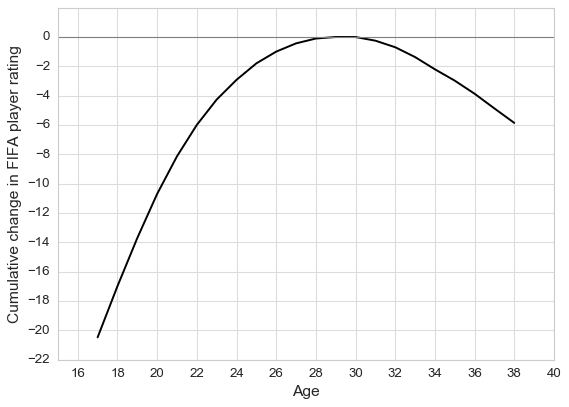

In [327]:
avg_rating_changes = year_over_year_ratings.groupby(['age', 'age_next_year'], as_index=False)['diff'].mean()
avg_rating_changes.columns = ['age', 'age_next_year', 'diff']

avg_rating_changes = avg_rating_changes.loc[(avg_rating_changes['age'] >= 16) & (avg_rating_changes['age_next_year'] <= 38)]
avg_rating_changes['cum_sum'] = avg_rating_changes['diff'].cumsum()
maximum_rating = avg_rating_changes['cum_sum'].max()
avg_rating_changes['aging_curve_rating'] = avg_rating_changes['cum_sum'] - maximum_rating

plt.plot(avg_rating_changes['age_next_year'], avg_rating_changes['aging_curve_rating'], color='black')
plt.style.use('seaborn-whitegrid')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Cumulative change in FIFA player rating', fontsize=14)
plt.xticks(np.arange(14, 42, 2))
plt.yticks(np.arange(np.round(min(avg_rating_changes['aging_curve_rating']))-2, 2, 2))
plt.ylim(-22, 2)
plt.xlim(15, 40)
plt.axhline(0, color='grey', linewidth=1)

plt.rc('xtick', labelsize=12)     
plt.rc('ytick', labelsize=12)

plt.grid(linestyle='-', linewidth=1, color='#DCDCDC')
plt.show()

#### Interpreting Aging Curves

We have constructed these age curves to have the cumulative change in FIFA rating max out at 0. This will simplify our analysis later on when we start comparing positions and individuals. This also allows us to draw the x-axis at the point at which players reach their maximum rating, making it easier to see at which age players peak. 

How should we interpret the y-axis? The cumulative change in FIFA rating is the average total progression that a player makes over the course of their career, starting from when they first become a professional and appear in a FIFA game. 

It would appear that players in FIFA reach their peak performance around the age of 28. The 'peak period' seems to last for about two years, until the age of 30. It appears that the average player begins their career 20 points below their maximum, and retires roughly 7 points below their peak.


#### Aging Curves for Top Players

Next, let us produce aging curves for a couple of top players. One restriction here is that FIFA player rating data is not available for the full duration of the careers of players like Cristiano Ronaldo and Luka Modric - but let's take a look at a few. To yield more complete aging curves, we will select players that appear to be at or close to their peak.

Text(0.06, 0.5, 'Cumulative Change in FIFA Rating')

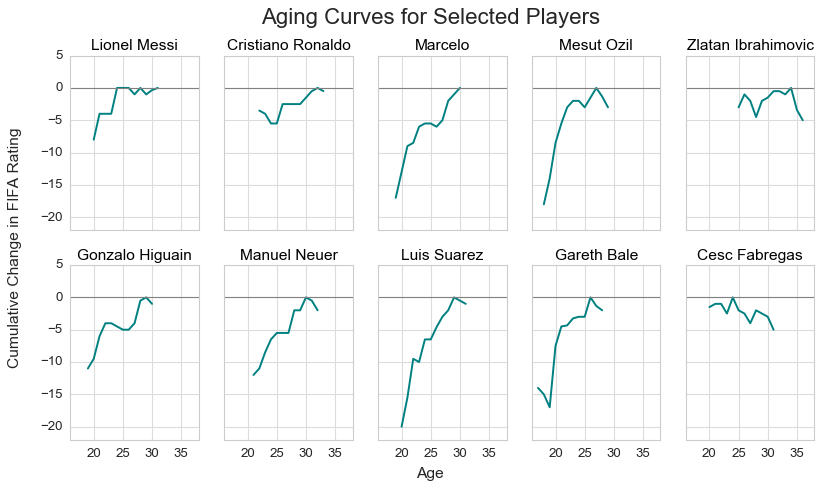

In [336]:
selected_players = ['Lionel Messi', 
                    'Cristiano Ronaldo', 
                    'Marcelo', 
                    'Mesut Ozil', 
                    'Zlatan Ibrahimovic', 
                    'Gonzalo Higuain', 
                    'Manuel Neuer', 
                    'Luis Suarez',
                    'Gareth Bale',
                    'Cesc Fabregas']

rating_changes_by_player = year_over_year_ratings.groupby(['age', 'age_next_year', 'name'], as_index=False)['diff'].mean()
rating_changes_by_player.columns = ['age', 'age_next_year', 'name', 'diff']
rating_changes_by_player = rating_changes_by_player.loc[(rating_changes_by_player['age'] >= 16) & (rating_changes_by_player['age_next_year'] <= 38)]

fig = plt.figure(figsize=(12, 6))

num = 0
for player in selected_players:
    num += 1
    
    position = rating_changes_by_player.loc[rating_changes_by_player['name'] == player]
    position['cum_sum'] = position['diff'].cumsum()
    maximum_cumsum = position['cum_sum'].max()
    position['aging_rating'] = position['cum_sum'] - maximum_cumsum
    
    ax = fig.add_subplot(2, 5, num)
    ax.patch.set_facecolor('white')
    ax.plot(position['age_next_year'], position['aging_rating'], color='#008080')
       
    ax.set_xlim(16, 38)
    ax.set_ylim(-22, 5)
    
    if num in range(6) :
        plt.tick_params(labelbottom=False)
        
    if num not in [1,6] :
        plt.tick_params(labelleft=False)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    
    plt.axhline(0, color='grey', linewidth=1)
    plt.title(player, fontsize=14, fontweight=0, color='black')
    plt.grid(linestyle='-', linewidth=1, color='#DCDCDC')

fig.suptitle('Aging Curves for Selected Players', y=1, fontsize=20)
fig.text(0.5, 0.02, 'Age', ha='center', fontsize=14)
fig.text(0.06, 0.5, 'Cumulative Change in FIFA Rating', va='center', rotation='vertical', fontsize=14)

The players outlined above are at various stages of their career and some may continue to progress.

Nevertheless, it is clear that players have very different aging trajectories. Lionel Messi and Cristiano Ronaldo have been close to their peak value from an early age (although some values are missing for Ronaldo in his early 20s). This is hardly surprising, given the fact that these two have dominated world soccer since the beginning of their careers. Their talent and skill was exceedingly apparent from the moment they appeared on the scene. It is noteworthy that these players have sustained their high rating levels for a very long period of time.

Zlatan Ibrahimovic, although missing some values for earlier in his career, has a similarly fascinating aging curve. It appears that he has peaked in his early- to mid-30s, later than most. 

Cesc Fabregas, by contrast, appears to have peaked at the young age of 24, before starting a gradual - although moderate - decline. 

The players above also differ in terms of the rise towards their peak. An important footnote to place here, however, is that there are missing ratings for players like Manuel Neuer, Messi, Ronaldo, Zlatan and Fabregas for their late teens/early 20s. This challenge arises from the fact that our ratings span 12 years (2006-2019), which is shorter than the full expected career span of top players. Thus, we are unable to produce complete aging curves for the full careers of these players. Fortunately, this problem is less of an issue when aggregating groups of players. Let us proceed by looking at how aging curves might differ by player position.

#### Aging Curves by Position

Conventional wisdom dictates that goalkeepers have greater longevity than attacking players. Wingers, who are more reliant on speed than players in central positions, may have lower longevity too (unless your name is Arjen Robben).

As a first step, let's make sure that the sample size for every position is large enough to enable the production of an aging curve - if necessary, we can consolidate similar positions.

In [329]:
all_positions = list(set(year_over_year_ratings['main_position']))

for pos in all_positions:
    one_position_only = year_over_year_ratings.loc[year_over_year_ratings['main_position'] == pos]
    print(pos, one_position_only.shape[0]) 

ST 88582
CM 65641
RW 15041
CDM 40983
RWB 2185
LWB 2329
RB 38739
CF 10013
RM 34689
LF 581
LB 37310
CAM 37946
RF 658
GK 50373
SW 110
LW 13564
CB 86856
LM 34090


It appears that certain positions only contain a few observations. RWB, LF, CF, RF, SW and LWB have very small samples. We will fold these positions in with the most similar position as follows:

CF (Center Forward) --> ST (Striker)
RWB (Right Wing Back) --> RB (Right Back)
LF (Left Forward) --> LW (Left Winger)
RF (Right Forward) --> RW (Right Winger)
SW (Sweeper) --> CB (Center Back)
LWB (Left Wing Back) --> LB (Left Back)

In [330]:
position_mapping = {'CF': 'ST', 'RWB': 'RB', 'LF': 'LW', 'RF': 'RW', 'SW': 'CB', 'LWB': 'LB'}

year_over_year_ratings['edited_position'] = year_over_year_ratings['main_position'].replace(position_mapping)
year_over_year_ratings.head()

,name,main_position,team,age,age_next_year,overall,next_year_overall,diff,age_couplet,edited_position
2,Stijn Stijnen,GK,Club Brugge KV,25,26,70,71.0,1.0,25/26,GK
3,Stijn Stijnen,GK,Club Brugge KV,26,27,71,73.0,2.0,26/27,GK
4,Stijn Stijnen,GK,Club Brugge KV,27,28,73,73.0,0.0,27/28,GK
5,Stijn Stijnen,GK,Club Brugge KV,27,28,73,72.0,-1.0,27/28,GK
6,Stijn Stijnen,GK,Club Brugge KV,28,29,73,73.0,0.0,28/29,GK


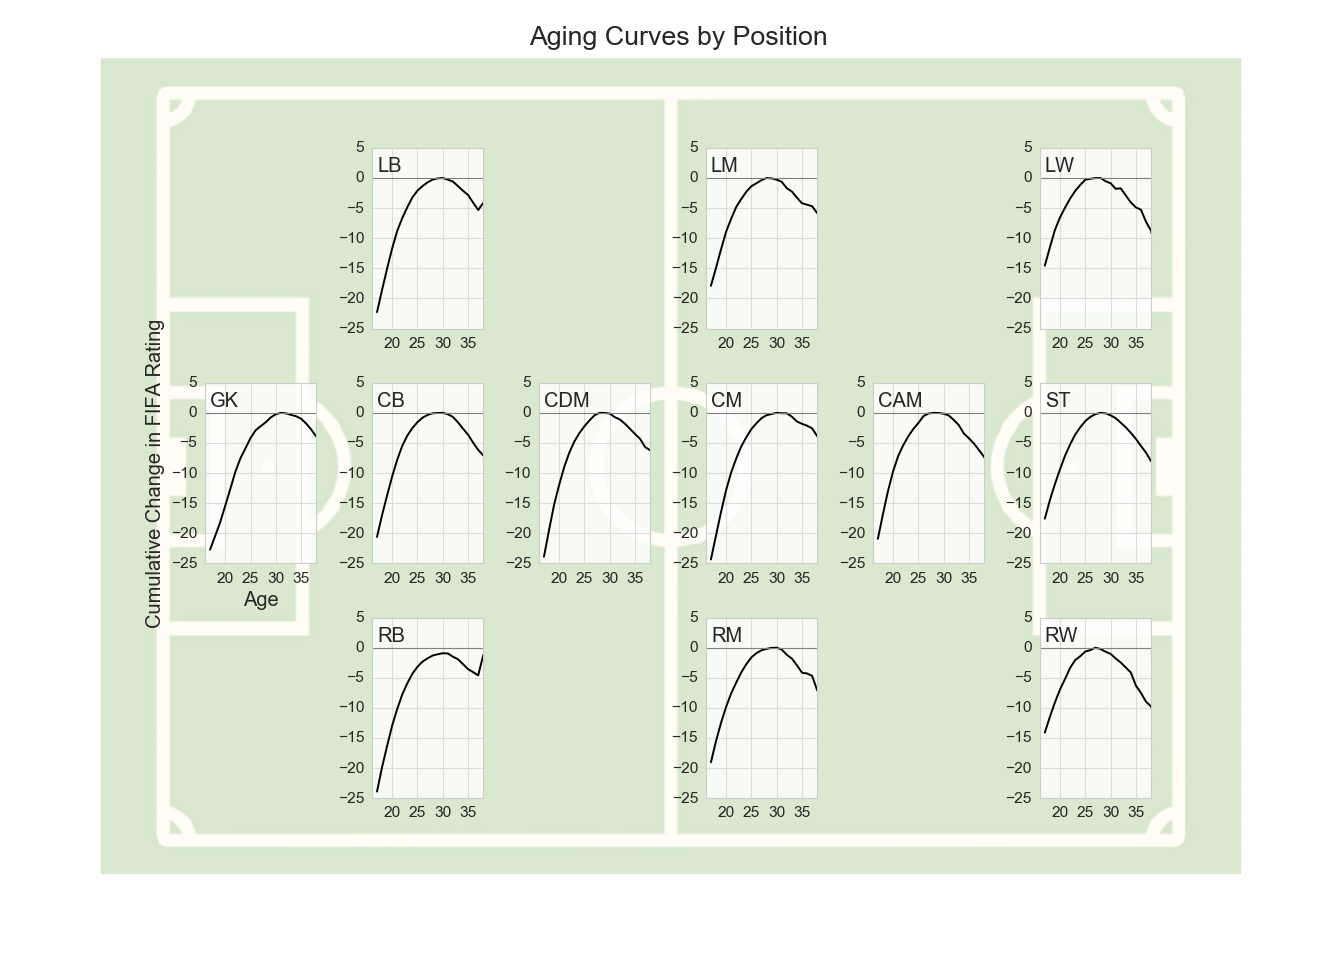

In [331]:
avg_rating_changes = year_over_year_ratings.groupby(['age', 'age_next_year', 'edited_position'], as_index=False)['diff'].mean()
avg_rating_changes.columns = ['age', 'age_next_year', 'edited_position', 'diff']
avg_rating_changes = avg_rating_changes.loc[(avg_rating_changes['age'] >= 16) & (avg_rating_changes['age'] <= 38)]

number_of_rows = 5
number_of_columns = 8
all_positions = {'GK': [number_of_rows, number_of_columns, 18], 
                 'RB': [number_of_rows, number_of_columns, 27], 
                 'CB': [number_of_rows, number_of_columns, 19], 
                 'LB': [number_of_rows, number_of_columns, 11], 
                 'CDM': [number_of_rows, number_of_columns, 20], 
                 'RM': [number_of_rows, number_of_columns, 29], 
                 'CM': [number_of_rows, number_of_columns, 21], 
                 'LM': [number_of_rows, number_of_columns, 13], 
                 'CAM': [number_of_rows, number_of_columns, 22], 
                 'RW': [number_of_rows, number_of_columns, 31], 
                 'ST': [number_of_rows, number_of_columns, 23], 
                 'LW': [number_of_rows, number_of_columns, 15],
                }

fig = plt.figure(figsize=(16, 14))
img = plt.imread("soccer_pitch_border.png")
plt.imshow(img)
plt.axis('off')

for key, value in all_positions.items():

    position = avg_rating_changes.loc[avg_rating_changes['edited_position'] == key]
    position['cum_sum'] = position['diff'].cumsum()
    maximum_cumsum = position['cum_sum'].max()
    position['aging_rating'] = position['cum_sum'] - maximum_cumsum
    
    peak = position.loc[position['aging_rating'] == 0]['age']
    peak = peak.iloc[0]
    
    ax = fig.add_subplot(value[0], value[1], value[2])
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(0.8)
    ax.plot(position['age_next_year'], position['aging_rating'], color='black')
    
    ax.text(17, 1, key, fontsize=18)
    
    ax.set_xlim(16, 38)
    ax.set_ylim(-25, 5)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    
    if key == 'GK':
        ax.set_xlabel('Age', fontsize=18)
        ax.set_ylabel('Cumulative Change in FIFA Rating', fontsize=18)
    
    plt.grid(linestyle='-', linewidth=1, color='#DCDCDC')
    plt.axhline(0, color='grey', linewidth=1)


fig.suptitle('Aging Curves by Position', y=0.9, fontsize=24)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.3)
plt.show()

At a glance, we can immediately start to draw some interesting conclusions:

-  Goalkeepers peak later than players in any other position (between ages 29 and 32)
-  Attacking players peak earlier than defensive players - especially wingers
-  Wingers start their careers much closer to their peak than central (and especially defensive) players. This implies that it may be easier to detect talent among wide attacking players than, for instance, goalkeepers

#### Analysis by team

In addition to analyzing aging curves by position, we can also construct average aging curves for various clubs. After all, certain clubs are known for their ability to develop young players, while others are thought to attract players at the peak of their career and invest less in youth development. 

For the purpose of this investigation, let us look at the top six teams from the Premier League: Liverpool, Manchester United, Manchester City, Chelsea, Tottenham Hotspur and Arsenal. These teams have very different reputations in terms of their investment in young vs. more experienced players and should make for an interesting set of clubs to compare.

Text(0.04, 0.5, 'Cumulative Change in FIFA Rating')

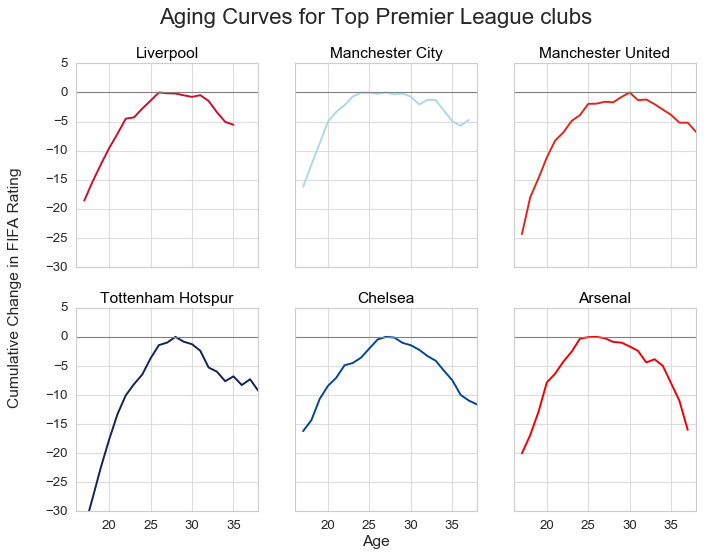

In [332]:
avg_rating_changes_by_team = year_over_year_ratings.groupby(['age', 'age_next_year', 'team'], as_index=False)['diff'].mean()
avg_rating_changes_by_team.columns = ['age', 'age_next_year', 'team', 'diff']
avg_rating_changes_by_team = avg_rating_changes_by_team.loc[(avg_rating_changes_by_team['age'] >= 16) & (avg_rating_changes_by_team['age_next_year'] <= 38)]

all_teams = {
                'Liverpool': '#C8102E',
                'Manchester City': '#ADD8E6',
                'Manchester United': '#DA291C',
                'Tottenham Hotspur': '#132257',
                'Chelsea': '#034694',
                'Arsenal': '#EF0107',
}

fig = plt.figure(figsize=(10, 7))

num = 0
for team, color in all_teams.items():
    num += 1
    
    position = avg_rating_changes_by_team.loc[avg_rating_changes_by_team['team'] == team]
    position['cum_sum'] = position['diff'].cumsum()
    maximum_cumsum = position['cum_sum'].max()
    position['aging_rating'] = position['cum_sum'] - maximum_cumsum
    
    ax = fig.add_subplot(2, 3, num)
    ax.patch.set_facecolor('white')
    ax.plot(position['age_next_year'], position['aging_rating'], color=color)
       
    ax.set_xlim(16, 38)
    ax.set_ylim(-30, 5)
    
    if num in range(4) :
        plt.tick_params(labelbottom=False)
        
    if num not in [1,4] :
        plt.tick_params(labelleft=False)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    
    plt.axhline(0, color='grey', linewidth=1)
    plt.title(team, fontsize=14, fontweight=0, color='black')
    plt.grid(linestyle='-', linewidth=1, color='#DCDCDC')

fig.suptitle('Aging Curves for Top Premier League clubs', y=1, fontsize=20)
fig.text(0.5, 0.04, 'Age', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Cumulative Change in FIFA Rating', va='center', rotation='vertical', fontsize=14)

It is apparent that the aging curves for the top Premier League clubs look very different. Of the top teams, Tottenham Hotspurs seems to invest most in the development of young players. Talented players get the opportunity to develop themselves, peaking around the age of 27. Manchester United players have a similar aging curve profile as Tottenham Hotspur players - they are given the opportunity to develop from a young age, improving gradually until they peak around 28-29. 

Manchester City players have a very different aging profile. Their players peak, on average, at the age of 23 and remain at a similar level until the age of 27. This is consistent with the reputation of the club, especially in recent years: acquiring world-class players for vast sums of money rather than investing in their youth academy. 

It is also worth spending a moment looking at how the top Premier League clubs differ in terms of how their players decline - Liverpool, Manchester City and Manchester United players appear to decline less from their peak as they age. The average difference between a player's peak and their rating at the age of 35 is about 5 points, versus approximately 10 for the three other clubs. It is not entirely clear what we should attribute this to - perhaps these clubs manage out declining players more actively, or employ older players for positions that decline less with age (defensive positions and goalkeepers). 

#### Conclusion

For those of you who would like to explore more slices of the aging curve dataset, the Github repo for this project also contains an interactive visualization tool that allows for the easy generation and comparison of aging curves. Alternatively, you can also use this link: https://mybinder.org/v2/gh/RoaldSchuring/Modeling-Football-Aging-Curves/f35dfea57337d0b62196bb69d0b863d36a87ef96?filepath=aging_curves_interactive_visualization.ipynb